### winPlacePerc 대신 winPlace를 사용하여 regression

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook
import gc

In [2]:
# dataframe display 옵션
pd.set_option('display.max_columns' , 30)
pd.set_option('display.width', None)

In [52]:
data = pd.read_csv('./data/train_V2.csv')
train_df, test_df = train_test_split(data, train_size = 0.7)

In [53]:
del data
gc.collect()

92

In [54]:
## 메모리 절약
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [55]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

In [56]:
# 회귀분석을 하기 위해 문자열을 범주값으로 변환
matchTyp = {'squad-fpp': 0, 'duo': 1, 'solo-fpp': 2, 'squad': 3, 'duo-fpp': 4, 'solo': 5,
       'normal-squad-fpp': 6, 'crashfpp': 7, 'flaretpp': 8, 'normal-solo-fpp': 9,
       'flarefpp': 10, 'normal-duo-fpp': 11, 'normal-duo': 12, 'normal-squad': 13,
       'crashtpp': 14, 'normal-solo': 15 }

train_df['matchType'] = train_df['matchType'].replace(matchTyp)
test_df['matchType'] = test_df['matchType'].replace(matchTyp)

In [57]:
# null값 확인 및 
# inplace=False로 하면 기존 혹은 새로운 변수에 할당해야 하고, inplace = True 하면 해당변수에 적용됨
# na가 포함된 행을 제거하는 것은 데이터 소실이 크기 때문에 inplace=False가 default
train_df.dropna(inplace = True)
print(train_df.isnull().any().any())
test_df.dropna(inplace = True)
print(test_df.isnull().any().any())

False
False


In [60]:
train_df['winPlace'] = train_df['winPlacePerc']*(train_df['maxPlace']-1)
test_df['winPlace'] = test_df['winPlacePerc']*(test_df['maxPlace']-1)

In [63]:
del train_df['winPlacePerc']
del test_df['winPlacePerc']

In [64]:
# drop함수와 dropna 함수는 데이터 소실 우려가 있기 때문에 할당하거나, inplace=True 매개변수를 가져야 정정되도록 default설정
r_train_df = train_df.drop(['groupId','matchId','roadKills','swimDistance','vehicleDestroys','teamKills','numGroups','damageDealt','killStreaks','matchDuration','killPlace','rankPoints','killPoints','DBNOs'], axis = 1)
r_test_df = test_df.drop(['groupId','matchId','roadKills','swimDistance','vehicleDestroys','teamKills','numGroups','damageDealt','killStreaks','matchDuration','killPlace','rankPoints','killPoints','DBNOs'], axis = 1)

In [65]:
solo_train_df = r_train_df[(r_train_df['matchType'] == 2) | (r_train_df['matchType'] == 5)]
solo_test_df = r_test_df[(r_test_df['matchType'] == 2) | (r_test_df['matchType'] == 5)]

In [66]:
del solo_train_df['matchType'] # 한 번만 실행
del solo_test_df['matchType'] # 한 번만 실행

In [87]:
solo_train_df

,Id,assists,boosts,headshotKills,heals,kills,longestKill,maxPlace,revives,rideDistance,walkDistance,weaponsAcquired,winPoints,winPlace
3073240,68b0506e7de51c,0,0,0,0,0,0.000000,97,0,0.00,17.015625,3,0,22.000000
1884210,50e33214e75074,0,3,0,1,0,0.000000,89,0,129.25,1778.000000,6,0,72.000000
2724794,dbf7c95629c219,0,0,0,0,0,0.000000,96,0,0.00,258.500000,4,0,46.000000
471825,29831e95b039bf,0,0,0,0,0,0.000000,92,0,0.00,0.000000,0,0,0.000000
1837424,d805b3e5542402,0,0,0,0,0,0.000000,92,0,0.00,16.375000,1,0,2.001953
3849120,354722652b7b58,0,0,0,0,0,0.000000,94,0,0.00,16.984375,1,0,15.992188
504569,bacf09adf1776f,0,0,0,0,0,0.000000,90,0,261.00,1007.000000,3,0,28.984375
1461154,22b009d763fcf3,1,1,0,0,0,0.000000,94,0,0.00,898.500000,6,1511,62.968750
1173064,9c7f16f518f1d1,0,0,0,0,0,0.000000,96,0,0.00,550.500000,2,0,43.000000
3396008,c385d6c9c18dbe,0,2,1,1,4,56.218750,95,0,0.00,3208.000000,3,1485,82.000000


In [105]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

total_ncol = len(solo_train_df.columns)
col_list = list(solo_train_df.columns)
col_list = col_list.remove('maxPlace')

train_np = np.array(solo_train_df[col_list])
test_np = np.array(solo_test_df[col_list])

x_train = MinMaxScaler(train_np[:,1:-1])
y_train = train_np[:, [-1]]
print('pass')

x_test = MinMaxScaler(test_np[:,1:-1]) # id, groupId, matchid 제외
y_test = test_np[:,[-1]]
print('pass')

# placeholders for a tensor that will be always fed.
X = tf.placeholder(tf.float32, shape=[None, total_ncol-3]) # id, winplaceperc,maxPlace 제외
Y = tf.placeholder(tf.float32, shape=[None, 1])

W = tf.Variable(tf.random_uniform([total_ncol-3, 1],-1.,1.), name='weight')
b = tf.Variable(tf.random_uniform([1],-1.,1.), name='bias')

# Hypothesis(model)
hypothesis = tf.matmul(X, W) + b
# Simplified cost/loss function
cost = tf.reduce_mean(tf.square(hypothesis - Y))

# Minimize
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05)
train = optimizer.minimize(cost)

# Launch the graph in a session.
with tf.Session() as sess:
    # Initializes global variables in the graph.
    sess.run(tf.global_variables_initializer())

    for step in tqdm_notebook(range(10001)):
        cost_val, hy_val, _ = sess.run(
            [cost, hypothesis, train], feed_dict={X: x_train, Y: y_train})
        if step % 100 == 0:
            print(step, "Cost: ", cost_val, "\nPrediction:\n", hy_val)
    Weight = sess.run(W)
    print("W\t" , Weight)
    y_predict = sess.run(hypothesis, feed_dict={X:x_test})
    print("Predict\t", y_predict)

pass
pass


0 Cost:  2954.272 
Prediction:
 [[-0.6326784 ]
 [-0.6539237 ]
 [-0.63501585]
 ...
 [-0.9663782 ]
 [-1.046122  ]
 [-0.64437044]]
100 Cost:  709.0917 
Prediction:
 [[42.71698 ]
 [44.919064]
 [42.83918 ]
 ...
 [47.44488 ]
 [46.31722 ]
 [43.07992 ]]
200 Cost:  649.83746 
Prediction:
 [[42.213947]
 [46.16425 ]
 [42.432743]
 ...
 [45.912544]
 [43.96075 ]
 [42.865902]]
300 Cost:  601.4338 
Prediction:
 [[41.259026]
 [46.81799 ]
 [41.56877 ]
 ...
 [45.209164]
 [42.487167]
 [42.181377]]
400 Cost:  561.0178 
Prediction:
 [[40.25588 ]
 [47.299152]
 [40.651592]
 ...
 [44.767937]
 [41.323013]
 [41.432167]]
500 Cost:  527.13403 
Prediction:
 [[39.305607]
 [47.720604]
 [39.782772]
 ...
 [44.433327]
 [40.308212]
 [40.72093 ]]
600 Cost:  498.62637 
Prediction:
 [[38.429127]
 [48.113403]
 [38.983627]
 ...
 [44.16011 ]
 [39.39381 ]
 [40.069897]]
700 Cost:  474.57465 
Prediction:
 [[37.626545]
 [48.486702]
 [38.25461 ]
 ...
 [43.932953]
 [38.56119 ]
 [39.48033 ]]
800 Cost:  454.2012 
Prediction:
 [[36.892

 [35.190624]]
6900 Cost:  266.48575 
Prediction:
 [[27.783983]
 [58.42449 ]
 [30.577822]
 ...
 [48.086197]
 [27.679342]
 [35.21181 ]]
7000 Cost:  265.69516 
Prediction:
 [[27.754885]
 [58.491722]
 [30.570086]
 ...
 [48.165306]
 [27.637348]
 [35.23296 ]]
7100 Cost:  264.91904 
Prediction:
 [[27.726269]
 [58.55754 ]
 [30.562626]
 ...
 [48.243332]
 [27.595903]
 [35.254063]]
7200 Cost:  264.1605 
Prediction:
 [[27.698116]
 [58.621986]
 [30.555426]
 ...
 [48.320297]
 [27.554985]
 [35.275112]]
7300 Cost:  263.4166 
Prediction:
 [[27.67041 ]
 [58.685078]
 [30.548473]
 ...
 [48.3962  ]
 [27.51458 ]
 [35.296104]]
7400 Cost:  262.68365 
Prediction:
 [[27.643131]
 [58.746857]
 [30.54175 ]
 ...
 [48.471054]
 [27.474665]
 [35.31702 ]]
7500 Cost:  261.96912 
Prediction:
 [[27.616276]
 [58.807365]
 [30.535255]
 ...
 [48.54489 ]
 [27.435236]
 [35.337868]]
7600 Cost:  261.2681 
Prediction:
 [[27.589823]
 [58.86662 ]
 [30.52897 ]
 ...
 [48.61771 ]
 [27.39627 ]
 [35.358635]]
7700 Cost:  260.57965 
Predic

In [106]:
test_id = pd.DataFrame(solo_test_df['Id'])
test_winPlace = pd.DataFrame(solo_test_df['winPlace'] ,columns=['winPlace'])
y_predict_df = pd.DataFrame(y_predict,index = test_id.index, columns=['predict'])
diff = pd.DataFrame((solo_test_df['winPlace']-y_predict_df['predict'])/(solo_test_df['maxPlace']-1),
                   columns=['diff'])

mae = sum(abs(diff['diff']))/diff['diff'].count() # Mean absolute error

result = pd.DataFrame({'Id':test_id['Id'],'winPlace':test_winPlace['winPlace'], 
                       'predict':y_predict_df['predict'],'diff':diff['diff'],'MAE':mae})
# result.to_csv("./result/solo_MLRegress_exclude_inputs(groupId,matchId,maxPlace,roadKills,swimDistance,vehicleDestroys,teamKills,numGroups,damageDealt,killStreaks,matchDuration,killPlace,rankPoints,killPoints,DBNOs,longestKill)_with_minmaxscaler.csv", sep=',', encoding='utf-8')
print(result.head())
print('Mae\t : ', mae)

                     Id  winPlace     predict      diff       MAE
8285     0dc501b255ea79      43.0   44.701401 -0.018100  0.247369
1372945  48c7684bdd40fc      28.0   41.459415 -0.143185  0.247369
2341366  d51b7aaf3a41af      81.0  133.122116 -0.560453  0.247369
10428    dad552cb2c5bb8      55.0   71.262894 -0.171188  0.247369
2702796  167e1395114719      28.0   39.666622 -0.121527  0.247369
Mae	 :  0.2473687445126092


### kaggle 50 rank mse : 0.0207... we have to go further

### solo 경기 회귀계수

In [130]:
col_list = list(solo_train_df.columns)
col_list.remove('maxPlace')
col_list.remove('Id')
col_list.remove('winPlace')
Weight_df = pd.DataFrame(Weight,columns=['Weight'])
col_df = pd.DataFrame(col_list, columns=['Variable'])
regress_df = pd.DataFrame([Weight_df['Weight'],col_df['Variable']])
regress_df.transpose()

,Weight,Variable
0,8.7719,assists
1,101.025,boosts
2,-0.847512,headshotKills
3,37.6842,heals
4,42.5662,kills
5,28.8402,longestKill
6,0.151348,revives
7,62.0568,rideDistance
8,278.393,walkDistance
9,116.869,weaponsAcquired


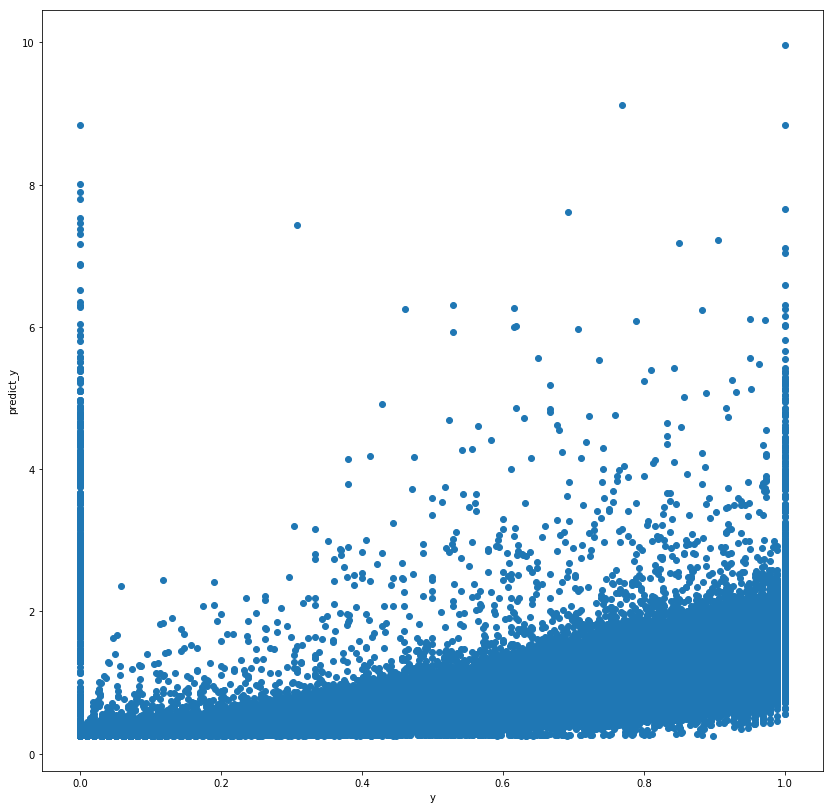

In [131]:
f, ax = plt.subplots(figsize=(14, 14))
plt.scatter(result['winPlace']/(solo_test_df['maxPlace']-1), result['predict']/(solo_test_df['maxPlace']-1))
plt.xlabel("y")
plt.ylabel("predict_y")
plt.show()